# Leveraging Momentum and Machine Learning to Predict 4th Down Conversion in the National Football League

### Introduction

For this article, we will define momentum and think about it in the following way. 

Good things and bad things happen in streaks. Positive momentum occurs when good things happen consistently and regularly over a period of time. Negative momentum occurs when bad things happen consistently and regularly over a period of time. Momentum exists in the present but also persists in longer and shorter phases that can stretch for minutes, hours, days, or months. People and groups of people can have momentum. Likewise, machines and other human-made creations also have momentum. 

As a data scientist, I develop metrics that capture momentum and use these metrics to make probabilistic predictions of the future.

Momentum in sports is a funny thing. You know it when you see it, but you can't predict when it will change, speed up or slow down.  

Many argue that momentum does not exist.

https://www.espn.com/college-football/story/_/id/32910904/is-momentum-real-depth-investigation-sports-most-overused-term 

I frankly don't get this. I don't see how anyone who is a sports fan or has played sports at any level can deny that momentum exists. Of course, it exists. Of course, you can gain momentum, and of course, you can lose momentum. Predicting when momentum will change is the tricky part. I don't see how that's possible. Also, momentum is not something an individual can control or turn on and off (although the great Mike Leach mentioned techniques to change negative momentum in the article referenced above, and if anyone could change momentum, it would be the late, great Coach Leach). Just because you can't control momentum does not mean you can not use it to make better decisions. That is what I do in this notebook. Using National Football League (NFL) data, I create a series of variables that capture the momentum between the teams playing. Then, I use these momentum variables to predict, with great accuracy, the likelihood of converting a 4th down conversion attempt. The great thing about the model I developed here is that it could be used in real time on the sideline. As long as they can capture the game's momentum, there is no reason a coach should not know with great accuracy the probability of converting a 4th down in the NFL.  


I created this model shortly after Dan Campbell's controversial decision to "go for it" on 4th down against the 49ers in the NFC Championship game. 

https://www.si.com/nfl/lions/news/dan-campell-explains-fourth-down-calls-49ers#:~:text=Campbell%20opted%20to%20keep%20Jared,Francisco%20scored%20on%20ensuing%20possessions.

According to the model, the odds of converting on fourth down at that moment were less than 15%. That is, there was an 85% chance of failing. Do you think Dan Campbell makes the same decision, armed with this information? I bet he takes the three points and keeps fighting on.

#### NOTE THAT YOU WILL NEED AT LEAST 16GB OF MEMORY RUN THIS NOTEBOOK.

### If you are not a data science guy, skip to section 6.0 for the conclusions to see the teams who made the best and worst 4th down decisions in 2023 and those who were the best and worst at converting on 4th down.

### Table of Contents

1.0 [Set up the Environment and Create Original Data Set](#one)<br>
2.0 [Feature Engineering -- Create Predictors that Capture the Momentum of the Game ](#two)<br>
3.0 [Finalize the Data Set](#three)<br>
4.0 [Create a Model](#four)<br>
5.0 [Build a Model with a Sub-Set of the derived Variables](#Five)<br>
6.0 [Interpret the Results](#six)<br>
7.0 [Conclusion](#seven)<br>

### 1.0 Set up the Environment and Create Original Data Set<a id="one"></a>   

Install appropriate Libraries.

In [1]:
!pip install nfl_data_py
!pip install xgboost

Import necessary python libraries.

In [2]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
import types


import plotly.graph_objs as go
import os, types

import plotly as plotly


Import data from NFL using the python library.

In [3]:
x=nfl.import_pbp_data([1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,
                      2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],  downcast=True, cache=False, alt_path=None)

1999 done.
2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


Select only the plays that were a pass or a run.

In [4]:
x=x[(x['play_type']=='pass') | (x['play_type']=='run')]

Select the fields will need for our model and reference fields.

In [5]:
x=x[['play_id', 'game_id', 'home_team', 'game_seconds_remaining', 'away_team', 'season_type', 'week', 'side_of_field', 
'yardline_100', 'game_date','posteam', 
'game_half', 'drive', 'qtr', 'down', 'time', 'yrdln', 'ydstogo','ydsnet', 
'play_type', 'yards_gained', 'home_timeouts_remaining','away_timeouts_remaining', 
'total_home_score', 'fumble_lost', 'total_away_score','interception',
 'home_wp', 'away_wp','vegas_home_wp',
'fourth_down_converted', 'touchdown', 'fourth_down_failed', 
'season', 'series', 'penalty_team', 'penalty_yards','rush_attempt','pass_attempt']]

### 2.0  Feature Engineering -- Create Predictors that Capture the Momentum of the Game <a id="two"></a>

Create a field reflecting yards gained times negative 1.  We will use this in constructing other features.

In [6]:
x['NEGATIVE_YARDS']=x['yards_gained']*(-1)

Create a flag that idenifies the home team and the away team.

In [7]:
x['HOME_OFFENSE']=np.where(((x.home_team == x.posteam)), 1, 0)
x['AWAY_OFFENSE']=np.where(((x.away_team == x.posteam)), 1, 0)


Identify Home Rushing and Away Rushing yards.

In [8]:
x['HOME_RUSH_YARDS']=x['HOME_OFFENSE']*x['yards_gained']*x['rush_attempt']

In [9]:
x['AWAY_RUSH_YARDS']=x['AWAY_OFFENSE']*x['yards_gained']*x['rush_attempt']

Identify Home and away passing yards.

In [10]:
x['AWAY_PASS_YARDS']=x['AWAY_OFFENSE']*x['yards_gained']*x['pass_attempt']
x['HOME_PASS_YARDS']=x['HOME_OFFENSE']*x['yards_gained']*x['pass_attempt']

Identify Home and Away Offensive Yards

In [11]:
x['HOME_OFFENSE_YARDS']=x['HOME_OFFENSE']*x['yards_gained']
x['AWAY_OFFENSE_YARDS']=x['AWAY_OFFENSE']*x['yards_gained']

Identify home and away fumbles and interceptions.

In [12]:
x['HOME_FUMBLES_LOST']=x['HOME_OFFENSE']*x['fumble_lost']
x['AWAY_FUMBLES_LOST']=x['AWAY_OFFENSE']*x['fumble_lost']

x['HOME_INTERCEPTION']=x['HOME_OFFENSE']*x['interception']
x['AWAY_INTERCEPTION']=x['AWAY_OFFENSE']*x['interception']


Identify home and away touchdowns.

In [13]:
x['HOME_TD']=x['HOME_OFFENSE']*x['touchdown']
x['AWAY_TD']=x['AWAY_OFFENSE']*x['touchdown']

Identify Home and Away net yards.

In [14]:
x['HOME_NET_YARDS']=np.where(((x.HOME_OFFENSE == 1)), x.yards_gained,x.NEGATIVE_YARDS)
x['AWAY_NET_YARDS']=np.where(((x.AWAY_OFFENSE == 1)), x.yards_gained,x.NEGATIVE_YARDS)





Identify Home and Away penalties and penalty yards.

In [15]:
x['HOME_PENALTY']=np.where(((x.home_team == x.penalty_team)), 1,0)
x['AWAY_PENALTY']=np.where(((x.away_team == x.penalty_team)), 1,0)
x['HOME_PENALTY_YARDS']=x['HOME_PENALTY']*x['penalty_yards']
x['AWAY_PENALTY_YARDS']=x['AWAY_PENALTY']*x['penalty_yards']

Idenfify big positive plays, those greater than 10, 20, 30, and 50 yards.

In [16]:
x['BIG_10'] = np.where((x.yards_gained>10), 1, 0)
x['BIG_20'] = np.where((x.yards_gained>20), 1, 0)
x['BIG_30'] = np.where((x.yards_gained>30), 1, 0)
x['BIG_50'] = np.where((x.yards_gained>50), 1, 0)

Idenfify big positive plays, those greater than 10, 20, 30, and 50 yards for the home and away team.

In [17]:
x['HOME_BIG_10'] = x['BIG_10']*x['HOME_OFFENSE']
x['HOME_BIG_20'] = x['BIG_20']*x['HOME_OFFENSE']
x['HOME_BIG_30'] = x['BIG_30']*x['HOME_OFFENSE']
x['HOME_BIG_50'] = x['BIG_50']*x['HOME_OFFENSE']

Identify big negative plays and associate them with the home team or the away team.

In [18]:
x['AWAY_BIG_10'] = x['BIG_10']*x['AWAY_OFFENSE']
x['AWAY_BIG_20'] = x['BIG_20']*x['AWAY_OFFENSE']
x['AWAY_BIG_30'] = x['BIG_30']*x['AWAY_OFFENSE']
x['AWAY_BIG_50'] = x['BIG_50']*x['AWAY_OFFENSE']

x['NEG_00'] = np.where((x.yards_gained<0), 1, 0)
x['NEG_05'] = np.where((x.yards_gained<-5), 1, 0)
x['NEG_10'] = np.where((x.yards_gained<-10), 1, 0)
x['NEG_15'] = np.where((x.yards_gained<-15), 1, 0)

x['HOME_NEG_00'] = x['NEG_00']*x['HOME_OFFENSE']
x['HOME_NEG_05'] = x['NEG_05']*x['HOME_OFFENSE']
x['HOME_NEG_10'] = x['NEG_10']*x['HOME_OFFENSE']
x['HOME_NEG_15'] = x['NEG_15']*x['HOME_OFFENSE']

x['AWAY_NEG_00'] = x['NEG_00']*x['AWAY_OFFENSE']
x['AWAY_NEG_05'] = x['NEG_05']*x['AWAY_OFFENSE']
x['AWAY_NEG_10'] = x['NEG_10']*x['AWAY_OFFENSE']
x['AWAY_NEG_15'] = x['NEG_15']*x['AWAY_OFFENSE']




Associate 4th down conversions and 4th down non-conversions with the home and away team.

In [19]:
x['HOME_4TH_CONV']=x['fourth_down_converted']*x['HOME_OFFENSE']
x['AWAY_4TH_CONV']=x['fourth_down_converted']*x['AWAY_OFFENSE']
x['HOME_4TH_FAIL']=x['fourth_down_failed']*x['HOME_OFFENSE']
x['AWAY_4TH_FAIL']=x['fourth_down_failed']*x['AWAY_OFFENSE']

Associate Rushing and passing attempts with the home and away team.

In [20]:
x['HOME_RUSH_ATTEMPT']=x['rush_attempt']*x['HOME_OFFENSE']
x['AWAY_RUSH_ATTEMPT']=x['rush_attempt']*x['AWAY_OFFENSE']
x['AWAY_PASS_ATTEMPT']=x['pass_attempt']*x['AWAY_OFFENSE']
x['HOME_PASS_ATTEMPT']=x['pass_attempt']*x['HOME_OFFENSE']

Reset the index to make sure it is sorted by season, game_id, play_id and game seconds remaining.

In [21]:
q=x.sort_values(by=['season','game_date','game_id','play_id','game_seconds_remaining'],ascending=[True,True,True,True,False])

q=q.reset_index()
q=q.rename(index=str, columns={"index": "wilma"})
q['wilma'] = q['wilma'].astype(str).astype(int)

q['wilma']=q['wilma']+1

q.head(3)

,wilma,play_id,game_id,home_team,game_seconds_remaining,away_team,season_type,week,side_of_field,yardline_100,...,AWAY_NEG_10,AWAY_NEG_15,HOME_4TH_CONV,AWAY_4TH_CONV,HOME_4TH_FAIL,AWAY_4TH_FAIL,HOME_RUSH_ATTEMPT,AWAY_RUSH_ATTEMPT,AWAY_PASS_ATTEMPT,HOME_PASS_ATTEMPT
0,2,60.0,1999_01_ARI_PHI,PHI,3600.0,ARI,REG,1,PHI,77.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3,82.0,1999_01_ARI_PHI,PHI,3600.0,ARI,REG,1,PHI,77.0,...,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,5,126.0,1999_01_ARI_PHI,PHI,3600.0,ARI,REG,1,PHI,81.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Find the minimum index value for each game.  We will need this value to build other features.

In [22]:
result = pd.DataFrame(q.groupby('game_id').agg({'wilma': ['min']}))
result=result.reset_index()
result=result.set_axis(['game_id', 'wilma_min'], axis='columns') 




Merge the minimum game_id back to each field in the original dataframe.

In [23]:
q = pd.merge(q,result, how="inner", on=["game_id"])

Ensure the file is sorted correctly

In [24]:
q=q.sort_values(by=['season','game_date','game_id','play_id','game_seconds_remaining'],ascending=[True,True,True,True,False])


Create short to medium term derived momentum variables.  For each of the fields we created, we will sum the data over the last 5, 10, 15 and 30 plays.

In [25]:
pebbles=[5,10,15,30]
for pebbles in pebbles:
    print(pebbles);

    fred='_'+str(pebbles)
    q['too_soon'] = np.where((q.wilma-q.wilma_min<=pebbles), 1, 0)
    q['HOME_NET_YARDS_SUM'+fred] = np.where((q.too_soon == 0),(q['HOME_NET_YARDS'].rolling(min_periods=1, window=pebbles).mean()) , -9999)
    q['HOME_OFFENSE_YARDS_SUM'+fred] = np.where((q.too_soon == 0),(q['HOME_OFFENSE_YARDS'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['AWAY_OFFENSE_YARDS_SUM'+fred] = np.where((q.too_soon == 0),(q['AWAY_OFFENSE_YARDS'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['AWAY_NET_YARDS_SUM'+fred] = np.where((q.too_soon == 0),(q['AWAY_NET_YARDS'].rolling(min_periods=1, window=pebbles).mean()) , -9999)
    
    q['HOME_OFFENSE_SUM'+fred] = np.where((q.too_soon == 0),(q['HOME_OFFENSE'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['AWAY_OFFENSE_SUM'+fred] = np.where((q.too_soon == 0),(q['AWAY_OFFENSE'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['HOME_OFFENSE_PCT'+fred] = np.where((q.too_soon == 0),(q['AWAY_OFFENSE_SUM'+fred]/(q['AWAY_OFFENSE_SUM'+fred]+q['AWAY_OFFENSE_SUM'+fred])) ,
                                          -9999)
    
    q=q.copy()
    
    
    q['AWAY_BIG_10_SUM'+fred] = np.where((q.too_soon == 0),(q['AWAY_BIG_10'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['AWAY_BIG_20_SUM'+fred] = np.where((q.too_soon == 0),(q['AWAY_BIG_20'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['AWAY_BIG_30_SUM'+fred] = np.where((q.too_soon == 0),(q['AWAY_BIG_30'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['AWAY_BIG_50_SUM'+fred] = np.where((q.too_soon == 0),(q['AWAY_BIG_50'].rolling(min_periods=1, window=pebbles).sum()) , -9999)

    q['AWAY_NEG_00_SUM'+fred] = np.where((q.too_soon == 0),(q['AWAY_NEG_00'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['AWAY_NEG_05_SUM'+fred] = np.where((q.too_soon == 0),(q['AWAY_NEG_05'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['AWAY_NEG_10_SUM'+fred] = np.where((q.too_soon == 0),(q['AWAY_NEG_10'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['AWAY_NEG_15_SUM'+fred] = np.where((q.too_soon == 0),(q['AWAY_NEG_15'].rolling(min_periods=1, window=pebbles).sum()) , -9999)

    q=q.copy()

    q['HOME_BIG_10_SUM'+fred] = np.where((q.too_soon == 0),(q['HOME_BIG_10'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['HOME_BIG_20_SUM'+fred] = np.where((q.too_soon == 0),(q['HOME_BIG_20'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['HOME_BIG_30_SUM'+fred] = np.where((q.too_soon == 0),(q['HOME_BIG_30'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['HOME_BIG_50_SUM'+fred] = np.where((q.too_soon == 0),(q['HOME_BIG_50'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['HOME_NEG_00_SUM'+fred] = np.where((q.too_soon == 0),(q['HOME_NEG_00'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['HOME_NEG_05_SUM'+fred] = np.where((q.too_soon == 0),(q['HOME_NEG_05'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['HOME_NEG_10_SUM'+fred] = np.where((q.too_soon == 0),(q['HOME_NEG_10'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['HOME_NEG_15_SUM'+fred] = np.where((q.too_soon == 0),(q['HOME_NEG_15'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['HOME_FUMBLES_SUM'+fred] = np.where((q.too_soon == 0),(q['HOME_FUMBLES_LOST'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['AWAY_FUMBLES_SUM'+fred] = np.where((q.too_soon == 0),(q['AWAY_FUMBLES_LOST'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['HOME_INTERCEPTION_SUM'+fred] = np.where((q.too_soon == 0),(q['HOME_INTERCEPTION'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['AWAY_INTERCEPTION_SUM'+fred] = np.where((q.too_soon == 0),(q['AWAY_INTERCEPTION'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['HOME_TURNOVER_SUM'+fred]=q['HOME_INTERCEPTION_SUM'+fred]+q['HOME_FUMBLES_SUM'+fred]
    q['AWAY_TURNOVER_SUM'+fred]=q['AWAY_INTERCEPTION_SUM'+fred]+q['AWAY_FUMBLES_SUM'+fred]



    q['HOME_TD_SUM'+fred] = np.where((q.too_soon == 0),(q['HOME_TD'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['AWAY_TD_SUM'+fred] = np.where((q.too_soon == 0),(q['AWAY_TD'].rolling(min_periods=1, window=pebbles).sum()) , -9999)


    q=q.copy()
    q['HOME_PENALTY_SUM'+fred] = np.where((q.too_soon == 0),(q['HOME_PENALTY'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['AWAY_PENALTY_SUM'+fred] = np.where((q.too_soon == 0),(q['AWAY_PENALTY'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['HOME_PENALTY_YDS_SUM'+fred] = np.where((q.too_soon == 0),(q['HOME_PENALTY_YARDS'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['AWAY_PENALTY_YDS_SUM'+fred] = np.where((q.too_soon == 0),(q['AWAY_PENALTY_YARDS'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    
    q['AWAY_RUSH_YDS_SUM'+fred] = np.where((q.too_soon == 0),(q['AWAY_RUSH_YARDS'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['HOME_RUSH_YDS_SUM'+fred] = np.where((q.too_soon == 0),(q['HOME_RUSH_YARDS'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['AWAY_RUSH_PLAYS_SUM'+fred] = np.where((q.too_soon == 0),(q['AWAY_RUSH_ATTEMPT'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['HOME_RUSH_PLAYS_SUM'+fred] = np.where((q.too_soon == 0),(q['HOME_RUSH_ATTEMPT'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['HOME_RUSH_YDS_PLAY'+fred]= np.where((q.too_soon == 0),(q['HOME_RUSH_YDS_SUM'+fred]/q['HOME_RUSH_PLAYS_SUM'+fred]) , -9999)
    q['AWAY_RUSH_YDS_PLAY'+fred]= np.where((q.too_soon == 0),(q['AWAY_RUSH_YDS_SUM'+fred]/q['AWAY_RUSH_PLAYS_SUM'+fred]) , -9999)
    
    q['AWAY_PASS_YDS_SUM'+fred] = np.where((q.too_soon == 0),(q['AWAY_PASS_YARDS'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['HOME_PASS_YDS_SUM'+fred] = np.where((q.too_soon == 0),(q['HOME_PASS_YARDS'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['AWAY_PASS_PLAYS_SUM'+fred] = np.where((q.too_soon == 0),(q['AWAY_PASS_ATTEMPT'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['HOME_PASS_PLAYS_SUM'+fred] = np.where((q.too_soon == 0),(q['HOME_PASS_ATTEMPT'].rolling(min_periods=1, window=pebbles).sum()) , -9999)
    q['HOME_PASS_YDS_PLAY'+fred]= np.where((q.too_soon == 0),(q['HOME_PASS_YDS_SUM'+fred]/q['HOME_PASS_PLAYS_SUM'+fred]) , -9999)
    q['AWAY_PASS_YDS_PLAY'+fred]= np.where((q.too_soon == 0),(q['AWAY_PASS_YDS_SUM'+fred]/q['AWAY_PASS_PLAYS_SUM'+fred]) , -9999)
    
    q['HOME_4TH_CONV'+fred] = np.where((q.HOME_4TH_CONV ==1),0,
                                 np.where((q.too_soon == 0),(q['HOME_4TH_CONV']
                                                                 .rolling(min_periods=1, window=pebbles).sum()) , -9999))
    q['AWAY_4TH_CONV'+fred] = np.where((q.AWAY_4TH_CONV ==1),0,
                                 np.where((q.too_soon == 0),(q['AWAY_4TH_CONV']
                                                                 .rolling(min_periods=1, window=pebbles).sum()) , -9999))
    
    
    q['HOME_4TH_FAIL'+fred] = np.where((q.HOME_4TH_CONV ==1),0,
                                 np.where((q.too_soon == 0),(q['HOME_4TH_FAIL']
                                                                 .rolling(min_periods=1, window=pebbles).sum()) , -9999))
    q['AWAY_4TH_FAIL'+fred] = np.where((q.AWAY_4TH_CONV ==1),0,
                                 np.where((q.too_soon == 0),(q['AWAY_4TH_FAIL']
                                                                 .rolling(min_periods=1, window=pebbles).sum()) , -9999))
    
    q=q.copy()

5
10
15
30


Sort the data.

In [26]:
q=q.sort_values(by=['season','game_date','game_id','play_id','game_seconds_remaining'],ascending=[True,True,True,True,False])

Create derived game situational momentum variables.  This time, cumulatively sum fields as the game progresses.

In [27]:

q['HOME_NET_YARDS_SUM'] = q.groupby(['game_id'])[['HOME_NET_YARDS']].cumsum()
q['HOME_OFFENSE_YARDS_SUM'] = q.groupby(['game_id'])[['HOME_OFFENSE_YARDS']].cumsum()

q['AWAY_NET_YARDS_SUM'] = q.groupby(['game_id'])[['AWAY_NET_YARDS']].cumsum()
q['AWAY_OFFENSE_YARDS_SUM'] = q.groupby(['game_id'])[['AWAY_OFFENSE_YARDS']].cumsum()
q['HOME_OFFENSE_SUM'] = q.groupby(['game_id'])[['HOME_OFFENSE']].cumsum()
q['AWAY_OFFENSE_SUM'] = q.groupby(['game_id'])[['AWAY_OFFENSE']].cumsum()


q['AWAY_4TH_FAIL_SUM'] = q.groupby(['game_id'])[['AWAY_4TH_FAIL']].cumsum()
q['HOME_4TH_FAIL_SUM'] = q.groupby(['game_id'])[['HOME_4TH_FAIL']].cumsum()
q['AWAY_4TH_CONV_SUM'] = q.groupby(['game_id'])[['AWAY_4TH_CONV']].cumsum()
q['HOME_4TH_CONV_SUM'] = q.groupby(['game_id'])[['HOME_4TH_CONV']].cumsum()



q['HOME_TD_SUM'] = q.groupby(['game_id'])[['HOME_TD']].cumsum()
q['AWAY_TD_SUM'] = q.groupby(['game_id'])[['AWAY_TD']].cumsum()



q['HOME_PENALTY_SUM'] = q.groupby(['game_id'])[['HOME_PENALTY']].cumsum()
q['AWAY_PENALTY_SUM'] = q.groupby(['game_id'])[['AWAY_PENALTY']].cumsum()
q['HOME_PENALTY_YDS_SUM'] = q.groupby(['game_id'])[['HOME_PENALTY_YARDS']].cumsum()
q['AWAY_PENALTY_YDS_SUM'] = q.groupby(['game_id'])[['AWAY_PENALTY_YARDS']].cumsum()


q['AWAY_RUSH_YDS_SUM'] = q.groupby(['game_id'])[['AWAY_RUSH_YARDS']].cumsum()
q['HOME_RUSH_YDS_SUM'] = q.groupby(['game_id'])[['HOME_RUSH_YARDS']].cumsum()
q['HOME_RUSH_PLAYS_SUM'] = q.groupby(['game_id'])[['HOME_RUSH_ATTEMPT']].cumsum()


q['AWAY_RUSH_PLAYS_SUM'] = q.groupby(['game_id'])[['AWAY_RUSH_ATTEMPT']].cumsum()


q['AWAY_PASS_YDS_SUM'] = q.groupby(['game_id'])[['AWAY_PASS_YARDS']].cumsum()
q['HOME_PASS_YDS_SUM'] = q.groupby(['game_id'])[['HOME_PASS_YARDS']].cumsum()

q['HOME_PASS_PLAYS_SUM'] = q.groupby(['game_id'])[['HOME_PASS_ATTEMPT']].cumsum()
q['AWAY_PASS_PLAYS_SUM'] = q.groupby(['game_id'])[['AWAY_PASS_ATTEMPT']].cumsum()


q['HOME_PASS_PLAYS_SUM'] = q.groupby(['game_id'])[['HOME_PASS_ATTEMPT']].cumsum()
q['AWAY_PASS_PLAYS_SUM'] = q.groupby(['game_id'])[['HOME_PASS_ATTEMPT']].cumsum()



q['AWAY_BIG_10_SUM'] = q.groupby(['game_id'])[['AWAY_BIG_10']].cumsum()
q['AWAY_BIG_20_SUM'] = q.groupby(['game_id'])[['AWAY_BIG_20']].cumsum()
q['AWAY_BIG_30_SUM'] = q.groupby(['game_id'])[['AWAY_BIG_30']].cumsum()
q['AWAY_BIG_50_SUM'] = q.groupby(['game_id'])[['AWAY_BIG_50']].cumsum()


In [28]:
q['HOME_BIG_10_SUM'] = q.groupby(['game_id'])[['HOME_BIG_10']].cumsum()
q['HOME_BIG_20_SUM'] = q.groupby(['game_id'])[['HOME_BIG_20']].cumsum()
q['HOME_BIG_30_SUM'] = q.groupby(['game_id'])[['HOME_BIG_30']].cumsum()
q['HOME_BIG_50_SUM'] = q.groupby(['game_id'])[['HOME_BIG_50']].cumsum()


In [29]:
q['HOME_NEG_00_SUM'] = q.groupby(['game_id'])[['HOME_NEG_00']].cumsum()
q['HOME_NEG_05_SUM'] = q.groupby(['game_id'])[['HOME_NEG_05']].cumsum()
q['HOME_NEG_10_SUM'] = q.groupby(['game_id'])[['HOME_NEG_10']].cumsum()
q['HOME_NEG_15_SUM'] = q.groupby(['game_id'])[['HOME_NEG_15']].cumsum()

In [30]:
q['AWAY_NEG_00_SUM'] = q.groupby(['game_id'])[['AWAY_NEG_00']].cumsum()
q['AWAY_NEG_05_SUM'] = q.groupby(['game_id'])[['AWAY_NEG_05']].cumsum()
q['AWAY_NEG_10_SUM'] = q.groupby(['game_id'])[['AWAY_NEG_10']].cumsum()
q['AWAY_NEG_15_SUM'] = q.groupby(['game_id'])[['AWAY_NEG_15']].cumsum()

In [31]:
q['HOME_FUMBLES_SUM'] = q.groupby(['game_id'])[['HOME_FUMBLES_LOST']].cumsum()
q['AWAY_FUMBLES_SUM'] = q.groupby(['game_id'])[['AWAY_FUMBLES_LOST']].cumsum()
q['AWAY_INTERCEPTION_SUM'] = q.groupby(['game_id'])[['AWAY_INTERCEPTION']].cumsum()
q['HOME_INTERCEPTION_SUM'] = q.groupby(['game_id'])[['HOME_INTERCEPTION']].cumsum()
q['HOME_TURNOVER_SUM']=q['HOME_INTERCEPTION_SUM']+q['HOME_FUMBLES_SUM']
q['AWAY_TURNOVER_SUM']=q['AWAY_INTERCEPTION_SUM']+q['AWAY_FUMBLES_SUM']

In [32]:
q['HOME_OFFENSE_PCT'] = (q['AWAY_OFFENSE_SUM']/(q['AWAY_OFFENSE_SUM']+q['AWAY_OFFENSE_SUM']))

In [33]:

q['HOME_RUSH_YDS_PLAY'] = (q['HOME_RUSH_YDS_SUM']/q['HOME_RUSH_PLAYS_SUM'])
q['AWAY_RUSH_YDS_PLAY'] = (q['AWAY_RUSH_YDS_SUM']/q['AWAY_RUSH_PLAYS_SUM'])
    
q['HOME_PASS_YDS_PLAY'] = (q['HOME_PASS_YDS_SUM']/q['HOME_PASS_PLAYS_SUM'])
q['AWAY_PASS_YDS_PLAY'] = (q['AWAY_PASS_YDS_SUM']/q['AWAY_PASS_PLAYS_SUM'])

Create angular momentum variables.  Try to identify situations where more recent statistics differ from game norms or trends.

In [34]:
barney=[5,10,15,30]
q=q.copy()
for barney in barney:
    print(barney);

    dino='_'+str(barney)
    
    
    
    q['D_HOME_RUSH_YDS_PLAY'+dino]=q['HOME_RUSH_YDS_PLAY'+dino]/q['HOME_RUSH_YDS_PLAY']
    q['D_HOME_NET_YARDS_SUM'+dino]=q['HOME_NET_YARDS_SUM'+dino]/q['HOME_NET_YARDS_SUM']
    q['D_HOME_OFFENSE_YARDS_SUM'+dino]=q['HOME_OFFENSE_YARDS_SUM'+dino]/q['HOME_OFFENSE_YARDS_SUM']
    q['D_AWAY_OFFENSE_YARDS_SUM'+dino]=q['AWAY_OFFENSE_YARDS_SUM'+dino]/q['AWAY_OFFENSE_YARDS_SUM']
    q['D_AWAY_NET_YARDS_SUM'+dino]=q['AWAY_NET_YARDS_SUM'+dino]/q['AWAY_NET_YARDS_SUM']
    q['D_HOME_OFFENSE_SUM'+dino]=q['HOME_OFFENSE_SUM'+dino]/q['HOME_OFFENSE_SUM']
    q['D_AWAY_OFFENSE_SUM'+dino]=q['AWAY_OFFENSE_SUM'+dino]/q['AWAY_OFFENSE_SUM']
    q['D_HOME_OFFENSE_PCT'+dino]=q['HOME_OFFENSE_PCT'+dino]/q['HOME_OFFENSE_PCT']
    q['D_AWAY_BIG_10_SUM'+dino]=q['AWAY_BIG_10_SUM'+dino]/q['AWAY_BIG_10_SUM']
    q['D_AWAY_BIG_20_SUM'+dino]=q['AWAY_BIG_20_SUM'+dino]/q['AWAY_BIG_20_SUM']
    q['D_AWAY_BIG_30_SUM'+dino]=q['AWAY_BIG_30_SUM'+dino]/q['AWAY_BIG_30_SUM']
    q['D_AWAY_BIG_50_SUM'+dino]=q['AWAY_BIG_50_SUM'+dino]/q['AWAY_BIG_50_SUM']
    q['D_AWAY_NEG_00_SUM'+dino]=q['AWAY_NEG_00_SUM'+dino]/q['AWAY_NEG_00_SUM']
    q['D_AWAY_NEG_05_SUM'+dino]=q['AWAY_NEG_05_SUM'+dino]/q['AWAY_NEG_05_SUM']
    q['D_AWAY_NEG_10_SUM'+dino]=q['AWAY_NEG_10_SUM'+dino]/q['AWAY_NEG_10_SUM']
    q['D_AWAY_NEG_15_SUM'+dino]=q['AWAY_NEG_15_SUM'+dino]/q['AWAY_NEG_15_SUM']
    q=q.copy()
    q['D_HOME_BIG_10_SUM'+dino]=q['HOME_BIG_10_SUM'+dino]/q['HOME_BIG_10_SUM']
    q['D_HOME_BIG_20_SUM'+dino]=q['HOME_BIG_20_SUM'+dino]/q['HOME_BIG_20_SUM']
    q['D_HOME_BIG_30_SUM'+dino]=q['HOME_BIG_30_SUM'+dino]/q['HOME_BIG_30_SUM']
    q['D_HOME_BIG_50_SUM'+dino]=q['HOME_BIG_50_SUM'+dino]/q['HOME_BIG_50_SUM']
    q['D_HOME_NEG_00_SUM'+dino]=q['HOME_NEG_00_SUM'+dino]/q['HOME_NEG_00_SUM']
    q['D_HOME_NEG_05_SUM'+dino]=q['HOME_NEG_05_SUM'+dino]/q['HOME_NEG_05_SUM']
    q['D_HOME_NEG_10_SUM'+dino]=q['HOME_NEG_10_SUM'+dino]/q['HOME_NEG_10_SUM']
    q['D_HOME_NEG_15_SUM'+dino]=q['HOME_NEG_15_SUM'+dino]/q['HOME_NEG_15_SUM']
    q=q.copy()
    q['D_HOME_FUMBLES_SUM'+dino]=q['HOME_FUMBLES_SUM'+dino]/q['HOME_FUMBLES_SUM']
    q['D_AWAY_FUMBLES_SUM'+dino]=q['AWAY_FUMBLES_SUM'+dino]/q['AWAY_FUMBLES_SUM']
    q['D_HOME_INTERCEPTION_SUM'+dino]=q['HOME_INTERCEPTION_SUM'+dino]/q['HOME_INTERCEPTION_SUM']
    q['D_AWAY_INTERCEPTION_SUM'+dino]=q['AWAY_INTERCEPTION_SUM'+dino]/q['AWAY_INTERCEPTION_SUM']
    q['D_HOME_TURNOVER_SUM'+dino]=q['HOME_TURNOVER_SUM'+dino]/q['HOME_TURNOVER_SUM']
    q['D_AWAY_TURNOVER_SUM'+dino]=q['AWAY_TURNOVER_SUM'+dino]/q['AWAY_TURNOVER_SUM']

    q['D_HOME_TD_SUM'+dino]=q['HOME_TD_SUM'+dino]/q['HOME_TD_SUM']
    q['D_AWAY_TD_SUM'+dino]=q['AWAY_TD_SUM'+dino]/q['AWAY_TD_SUM']
    q['D_HOME_PENALTY_SUM'+dino]=q['HOME_PENALTY_SUM'+dino]/q['HOME_PENALTY_SUM']
    q['D_AWAY_PENALTY_SUM'+dino]=q['AWAY_PENALTY_SUM'+dino]/q['AWAY_PENALTY_SUM']
    q['D_HOME_PENALTY_YDS_SUM'+dino]=q['HOME_PENALTY_YDS_SUM'+dino]/q['HOME_PENALTY_YDS_SUM']
    q['D_AWAY_PENALTY_YDS_SUM'+dino]=q['AWAY_PENALTY_YDS_SUM'+dino]/q['AWAY_PENALTY_YDS_SUM']
    q['D_AWAY_RUSH_YDS_SUM'+dino]=q['AWAY_RUSH_YDS_SUM'+dino]/q['AWAY_RUSH_YDS_SUM']
    q['D_HOME_RUSH_YDS_SUM'+dino]=q['HOME_RUSH_YDS_SUM'+dino]/q['HOME_RUSH_YDS_SUM']
    q['D_AWAY_RUSH_PLAYS_SUM'+dino]=q['AWAY_RUSH_PLAYS_SUM'+dino]/q['AWAY_RUSH_PLAYS_SUM']
    q['D_HOME_RUSH_PLAYS_SUM'+dino]=q['HOME_RUSH_PLAYS_SUM'+dino]/q['HOME_RUSH_PLAYS_SUM']
    q['D_HOME_RUSH_YDS_PLAY'+dino]=q['HOME_RUSH_YDS_PLAY'+dino]/q['HOME_RUSH_YDS_PLAY']
    q['D_AWAY_RUSH_YDS_PLAY'+dino]=q['AWAY_RUSH_YDS_PLAY'+dino]/q['AWAY_RUSH_YDS_PLAY']
    q['D_HOME_4TH_CONV'+dino]=q['HOME_4TH_CONV'+dino]/q['HOME_4TH_CONV']
    q['D_HOME_4TH_FAIL'+dino]=q['HOME_4TH_FAIL'+dino]/q['HOME_4TH_FAIL']
    q['D_AWAY_4TH_FAIL'+dino]=q['AWAY_4TH_FAIL'+dino]/q['AWAY_4TH_FAIL']
    q['D_AWAY_PASS_YDS_SUM'+dino]=q['AWAY_PASS_YDS_SUM'+dino]/q['AWAY_PASS_YDS_SUM']
    q['D_HOME_PASS_YDS_SUM'+dino]=q['HOME_PASS_YDS_SUM'+dino]/q['HOME_PASS_YDS_SUM']
    q['D_AWAY_PASS_PLAYS_SUM'+dino]=q['AWAY_PASS_PLAYS_SUM'+dino]/q['AWAY_PASS_PLAYS_SUM']
    q['D_HOME_PASS_PLAYS_SUM'+dino]=q['HOME_PASS_PLAYS_SUM'+dino]/q['HOME_PASS_PLAYS_SUM']
    q['D_HOME_PASS_YDS_PLAY'+dino]=q['HOME_PASS_YDS_PLAY'+dino]/q['HOME_PASS_YDS_PLAY']
    q['D_AWAY_PASS_YDS_PLAY'+dino]=q['AWAY_PASS_YDS_PLAY'+dino]/q['AWAY_PASS_YDS_PLAY']
    


5
10
15
30


In [35]:
q=q.copy()

Sort data.

In [36]:
q=q.sort_values(by=['season','game_date','game_id','play_id','game_seconds_remaining'],ascending=[True,True,True,True,False])

Identify and keep all fields that are known before the ball is snapped on fourth down and the dependent variable. We will also include penalty_yards so that we can elimnate 4th downs converted via penalty later on.

In [37]:
greatgazoo=q[['wilma', 'play_id', 'game_id', 'home_team', 'game_seconds_remaining', 'away_team', 
             'season_type', 'week', 'side_of_field', 'yardline_100', 'game_date', 'posteam', 
             'game_half', 'drive',  'qtr', 'down', 'time', 'yrdln', 'ydstogo','play_type',
             'home_timeouts_remaining', 'away_timeouts_remaining',
            'season', 'series','fourth_down_failed','fourth_down_converted','penalty_yards','rush_attempt', 'pass_attempt']]

Identify and drop all fields that are known before the ball is snapped on fourth down and the dependent variable. 

In [38]:
mr_slate=q.drop(['play_id', 'game_id', 'home_team', 'game_seconds_remaining', 'away_team', 
             'season_type', 'week', 'side_of_field', 'yardline_100', 'game_date', 'posteam', 
             'game_half', 'drive', 'qtr', 'down', 'time', 'yrdln', 'ydstogo','play_type',
             'home_timeouts_remaining', 'away_timeouts_remaining',
            'season', 'series','rush_attempt', 'pass_attempt','fourth_down_failed','penalty_yards',
                 'fourth_down_converted'], axis=1)

Create a new variable that will retain the original index (wilma).

In [39]:
mr_slate['old_wilma']=mr_slate['wilma']

Add 1 to the index, shifting the values of third down to fourth down for all variables that are known after the ball is snapped.

In [40]:
mr_slate['wilma']=mr_slate['wilma']+1

Merge to the original dataframe.  This means that only values known before the ball is snapped will be used to predict 4th down conversion.

In [41]:
z = pd.merge(greatgazoo,mr_slate, how="inner", on=["wilma"])

### 3.0  Finalize the Data Set <a id="three"></a>

Select only 4th down plays.

In [42]:
z=z[((z['fourth_down_converted']==1) | (z['fourth_down_failed']==1))]
z.shape

(10609, 551)

Fill missing values with 0

In [43]:
z=z.fillna(0)

Get rid of 4th downs converted via penalty. After doing so, we will have 10,459 records in the dataset.

In [44]:
z=z[z['penalty_yards']==0]
z.shape

(10459, 551)

Get rid of whether the play was a run or a pass. Note that because the play is known before the snap of the ball, you could use these variables to calculate the probability of converting with a run play and the likelihood of converting with a pass play. We'll save that exercise later and exclude these fields from the data set.

In [45]:
z=z.drop(['rush_attempt', 'pass_attempt'], axis=1)

Select the home team from each game.

In [46]:
home=z[z['home_team']==z['posteam']]
home.head()

,wilma,play_id,game_id,home_team,game_seconds_remaining,away_team,season_type,week,side_of_field,yardline_100,...,D_HOME_4TH_CONV_30,D_HOME_4TH_FAIL_30,D_AWAY_4TH_FAIL_30,D_AWAY_PASS_YDS_SUM_30,D_HOME_PASS_YDS_SUM_30,D_AWAY_PASS_PLAYS_SUM_30,D_HOME_PASS_PLAYS_SUM_30,D_HOME_PASS_YDS_PLAY_30,D_AWAY_PASS_YDS_PLAY_30,old_wilma
339,721,3802.0,1999_01_CIN_TEN,TEN,476.0,CIN,REG,1,CIN,41.0,...,0.0,0.0,0.0,0.043956,0.192727,0.142857,0.392857,0.490579,0.307692,720
478,1019,1407.0,1999_01_DET_SEA,SEA,2426.0,DET,REG,1,SEA,88.0,...,0.0,0.0,0.0,1.012987,1.272727,0.818182,0.727273,1.750000,1.238095,1018
717,1697,553.0,1999_01_NE_NYJ,NYJ,3235.0,NE,REG,1,NE,40.0,...,-inf,-inf,-inf,-136.972603,-588.176471,-2499.750000,-2499.750000,-2352.705882,-547.890411,1696
769,1809,3104.0,1999_01_NE_NYJ,NYJ,900.0,NE,REG,1,NE,14.0,...,0.0,0.0,0.0,0.370370,0.349345,0.212121,0.333333,1.048035,1.746032,1808
870,2026,4270.0,1999_01_NYG_TB,TB,92.0,NYG,REG,1,TB,69.0,...,0.0,0.0,0.0,0.113924,0.079096,0.139535,0.279070,0.283427,0.816456,2025


Recode from the perspective of the home team.  A column that is Home becomes US.  A column that is away is them.

In [47]:
home.columns = [col.replace('HOME', 'US') for col in home.columns] 
home.columns = [col.replace('AWAY', 'THEM') for col in home.columns] 
home.columns = [col.replace('home', 'US') for col in home.columns] 
home.columns = [col.replace('away', 'THEM') for col in home.columns] 

In [48]:
home.head(1)

,wilma,play_id,game_id,US_team,game_seconds_remaining,THEM_team,season_type,week,side_of_field,yardline_100,...,D_US_4TH_CONV_30,D_US_4TH_FAIL_30,D_THEM_4TH_FAIL_30,D_THEM_PASS_YDS_SUM_30,D_US_PASS_YDS_SUM_30,D_THEM_PASS_PLAYS_SUM_30,D_US_PASS_PLAYS_SUM_30,D_US_PASS_YDS_PLAY_30,D_THEM_PASS_YDS_PLAY_30,old_wilma
339,721,3802.0,1999_01_CIN_TEN,TEN,476.0,CIN,REG,1,CIN,41.0,...,0.0,0.0,0.0,0.043956,0.192727,0.142857,0.392857,0.490579,0.307692,720


Select the away team from each game.

In [49]:
away=z[z['home_team']!=z['posteam']]
away.head()

,wilma,play_id,game_id,home_team,game_seconds_remaining,away_team,season_type,week,side_of_field,yardline_100,...,D_HOME_4TH_CONV_30,D_HOME_4TH_FAIL_30,D_AWAY_4TH_FAIL_30,D_AWAY_PASS_YDS_SUM_30,D_HOME_PASS_YDS_SUM_30,D_AWAY_PASS_PLAYS_SUM_30,D_HOME_PASS_PLAYS_SUM_30,D_HOME_PASS_YDS_PLAY_30,D_AWAY_PASS_YDS_PLAY_30,old_wilma
54,113,2667.0,1999_01_ARI_PHI,PHI,1800.0,ARI,REG,1,PHI,38.0,...,0.0,0.0,0.0,0.427083,0.166667,0.700000,0.500000,0.333333,0.610119,112
427,893,3546.0,1999_01_DAL_WAS,WAS,643.0,DAL,REG,1,WAS,28.0,...,0.0,0.0,0.0,0.197080,0.236066,0.363636,0.136364,1.731148,0.541971,892
434,902,3756.0,1999_01_DAL_WAS,WAS,375.0,DAL,REG,1,WAS,40.0,...,0.0,0.0,inf,0.290323,0.163934,0.478261,0.086957,1.885246,0.607038,901
618,1319,4620.0,1999_01_KC_CHI,CHI,179.0,KC,REG,1,CHI,47.0,...,0.0,0.0,0.0,0.151079,0.182410,0.217391,0.260870,0.699240,0.694964,1318
621,1330,4863.0,1999_01_KC_CHI,CHI,110.0,KC,REG,1,KC,93.0,...,0.0,0.0,inf,0.151079,0.058632,0.276596,0.170213,0.344463,0.546209,1329


Recode from the perspective of the away team.  A column that is Home becomes THEM.  A column that is away is US.

In [50]:
away.columns = [col.replace('AWAY', 'US') for col in away.columns] 
away.columns = [col.replace('HOME', 'THEM') for col in away.columns] 
away.columns = [col.replace('away', 'US') for col in away.columns] 
away.columns = [col.replace('home', 'THEM') for col in away.columns] 

Concentate the two datasets.  Now the team in possession has their statistics as US and the non-possesion team has their statistics as THEM for each 4th down play.

In [51]:
y=pd.concat([home,away])

y=y.sort_values(by=['season','game_date','game_id','play_id','game_seconds_remaining'],ascending=[True,True,True,True,False])

Reset the index.

In [52]:
y=y.sort_values(by=['season','game_date','game_id','play_id','game_seconds_remaining'],ascending=[True,True,True,True,False])

y=y.reset_index()
y=y.rename(index=str, columns={"index": "BETTY"})
y['BETTY'] = y['BETTY'].astype(str).astype(int)

y['BETTY']=y['BETTY']+1

y.head(3)

,BETTY,wilma,play_id,game_id,US_team,game_seconds_remaining,THEM_team,season_type,week,side_of_field,...,THEM_OFFENSE_PCT_30,THEM_OFFENSE_PCT,D_THEM_OFFENSE_PCT_5,D_THEM_4TH_CONV_5,D_THEM_OFFENSE_PCT_10,D_THEM_4TH_CONV_10,D_THEM_OFFENSE_PCT_15,D_THEM_4TH_CONV_15,D_THEM_OFFENSE_PCT_30,D_THEM_4TH_CONV_30
0,55,113,2667.0,1999_01_ARI_PHI,ARI,1800.0,PHI,REG,1,PHI,...,0.5,0.5,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,340,721,3802.0,1999_01_CIN_TEN,TEN,476.0,CIN,REG,1,CIN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,428,893,3546.0,1999_01_DAL_WAS,DAL,643.0,WAS,REG,1,WAS,...,0.5,0.5,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


Drop the old index.

In [53]:
y=y.drop([ 'wilma','old_wilma'], axis=1)

In [54]:
y.head()

,BETTY,play_id,game_id,US_team,game_seconds_remaining,THEM_team,season_type,week,side_of_field,yardline_100,...,THEM_OFFENSE_PCT_30,THEM_OFFENSE_PCT,D_THEM_OFFENSE_PCT_5,D_THEM_4TH_CONV_5,D_THEM_OFFENSE_PCT_10,D_THEM_4TH_CONV_10,D_THEM_OFFENSE_PCT_15,D_THEM_4TH_CONV_15,D_THEM_OFFENSE_PCT_30,D_THEM_4TH_CONV_30
0,55,2667.0,1999_01_ARI_PHI,ARI,1800.0,PHI,REG,1,PHI,38.0,...,0.5,0.5,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,340,3802.0,1999_01_CIN_TEN,TEN,476.0,CIN,REG,1,CIN,41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,428,3546.0,1999_01_DAL_WAS,DAL,643.0,WAS,REG,1,WAS,28.0,...,0.5,0.5,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,435,3756.0,1999_01_DAL_WAS,DAL,375.0,WAS,REG,1,WAS,40.0,...,0.5,0.5,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,479,1407.0,1999_01_DET_SEA,SEA,2426.0,DET,REG,1,SEA,88.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Get rid of fields that have historical value as we derive the momentum features but are not meaningful on 4th down.

In [55]:
df=y.drop(['US_PENALTY','THEM_PENALTY','US_OFFENSE','THEM_OFFENSE','THEM_RUSH_YARDS','THEM_PASS_YARDS',
         'THEM_OFFENSE_YARDS','THEM_PENALTY','THEM_PENALTY_YARDS','THEM_BIG_10','THEM_BIG_20','THEM_NEG_00',
         'THEM_NEG_05','THEM_NEG_10','THEM_RUSH_ATTEMPT','THEM_PASS_ATTEMPT','D_THEM_PENALTY_YDS_SUM_5',
         'D_THEM_PENALTY_YDS_SUM_10','D_THEM_PENALTY_YDS_SUM_15','D_THEM_PENALTY_YDS_SUM_30','NEGATIVE_YARDS'], axis=1)

Create a dependent variable.

In [56]:
df['FOURTH_CONV'] = np.where((df.fourth_down_converted), 1, 0)

In [57]:
df['FOURTH_CONV'].value_counts()

1    5277
0    5182
Name: FOURTH_CONV, dtype: int64

Interestingly, the historical 4th down conversion rate is about 50%.  

Engineer a feature to identify if the play occured during the first or second half.

In [58]:
df['first_half']= np.where((df.game_half=='Half2'), 0, 1)

Create a modeling group that includes the seasons spanning from 1999 to 2021.  Create a testing group that contains 4th down plays from 2022 and 2023.  The objective is to build a model on data from 1999 to 2021 and test it on data on data from 2022 and 2023.

In [59]:
df['MODELING_GROUP'] = np.where((df.season==2022), 'TESTING', 
                               np.where((df.season==2023), 'TESTING', 'TRAINING'))

Get a count of the number of records in each Modeling Group

In [60]:
df['MODELING_GROUP'].value_counts()

TRAINING    9199
TESTING     1260
Name: MODELING_GROUP, dtype: int64

Clean up the data set a little more.

In [61]:
df=df.drop(columns =['US_team', 'THEM_team', 'season_type', 'side_of_field', 'game_date', 'game_half', 
                     'time', 'yrdln', 'play_type', 'penalty_team','wilma_min','season','week','fourth_down_failed',
                     'fourth_down_converted','penalty_yards'])

Create a list that contains all of the field names.

In [62]:
x=(df.columns.tolist())


Replace infinite values with a crazy number.

In [63]:
df.replace([np.inf, -np.inf], -1010101, inplace=True)

Create two data frames.  One for testing and one for training.

In [64]:
df_training=df[df['MODELING_GROUP']=='TRAINING']
df_testing=df[df['MODELING_GROUP']=='TESTING']


### 4.0  Create a Model <a id="four"></a>

Define the features, dependent variable and independent variables.

In [65]:
features = [x for x in df_training.columns if x not in ['FOURTH_CONV','MODELING_GROUP','BETTY','posteam','game_id']]  
dependent=pd.DataFrame(df_training['FOURTH_CONV'])
independent=df_training.drop(columns=['FOURTH_CONV','MODELING_GROUP','BETTY','posteam','game_id'])

Set the hyper-parmameters.

In [66]:
estimator_vals = 215
lr_vals =.05
md_vals =10
mcw_vals =5
gamma_vals=.1
mds_vals = 3

Build the model on the training data and test on the testing data.

In [67]:
xgb0 = XGBClassifier(objective = 'binary:logistic',learning_rate = lr_vals,
                                 n_estimators=estimator_vals,max_depth=md_vals,min_child_weight=mcw_vals,gamma=gamma_vals,
                                        max_delta_step=mds_vals);
xgb0.fit(independent, dependent) 
df_training=df_training.copy()
df_training['P_FOURTH_CONV']= xgb0.predict_proba(df_training[features])[:,1];
df_training=df_training.copy()
df_training['Y_FOURTH_CONV'] = np.where(((df_training.P_FOURTH_CONV <= .5)), 0, 1)
df_training=df_training.copy()
print('Training Data -- 1999 through 2021')                        
print("Accuracy : %.4g" % metrics.accuracy_score(df_training['FOURTH_CONV'].values, df_training['Y_FOURTH_CONV']))
print("AUC Score (Train): %f" % metrics.roc_auc_score(df_training['FOURTH_CONV'], df_training['P_FOURTH_CONV']))
print("Precision Score (Train): %f" % metrics.precision_score(df_training['FOURTH_CONV'], df_training['Y_FOURTH_CONV']));
#print("testing--",estimator_vals,lr_vals ,md_vals,mcw_vals,gamma_vals,mds_vals);
df_testing=df_testing.copy()
df_testing['P_FOURTH_CONV']= xgb0.predict_proba(df_testing[features])[:,1];
df_testing=df_testing.copy()
df_testing['Y_FOURTH_CONV'] = np.where(((df_testing.P_FOURTH_CONV <= .5)), 0, 1)
#Print model report:
print('Testing Data -- 2022 and 2023')
print("Accuracy : %.4g" % metrics.accuracy_score(df_testing['FOURTH_CONV'].values, df_testing['Y_FOURTH_CONV']))
print("AUC Score (Testing): %f" % metrics.roc_auc_score(df_testing['FOURTH_CONV'], df_testing['P_FOURTH_CONV']))
print("Precision Score (Testing): %f" % metrics.precision_score(df_testing['FOURTH_CONV'], df_testing['Y_FOURTH_CONV']))

Training Data -- 1999 through 2021
Accuracy : 0.9985
AUC Score (Train): 0.999938
Precision Score (Train): 0.998912
Testing Data -- 2022 and 2023
Accuracy : 0.8738
AUC Score (Testing): 0.947118
Precision Score (Testing): 0.888889


Accuracy in the testing set is 87.34%

Let's examine a confusion matrix.

In [68]:
print(pd.crosstab(df_testing.FOURTH_CONV, df_testing.Y_FOURTH_CONV, dropna=False, margins=True))

Y_FOURTH_CONV    0    1   All
FOURTH_CONV                  
0              509   74   583
1               85  592   677
All            594  666  1260


If the model predicts a non-conversion, it will be wrong about 14% of the time, right 86% of the time.  If the model predicts a conversion, it will be wrong about 11% of the time and correct 89% of the time. Given the human element, this is amazing accuracy.  For example, a coach can call the perfect play but executing a perfect play is hard.  Really hard.  Accuracy metrics better are almost impossible to attain, because there are so many uncontrollable variables in the execution.

Now we will examine the importance features.

In [69]:
df_whole_model=df_testing

<Axes: >

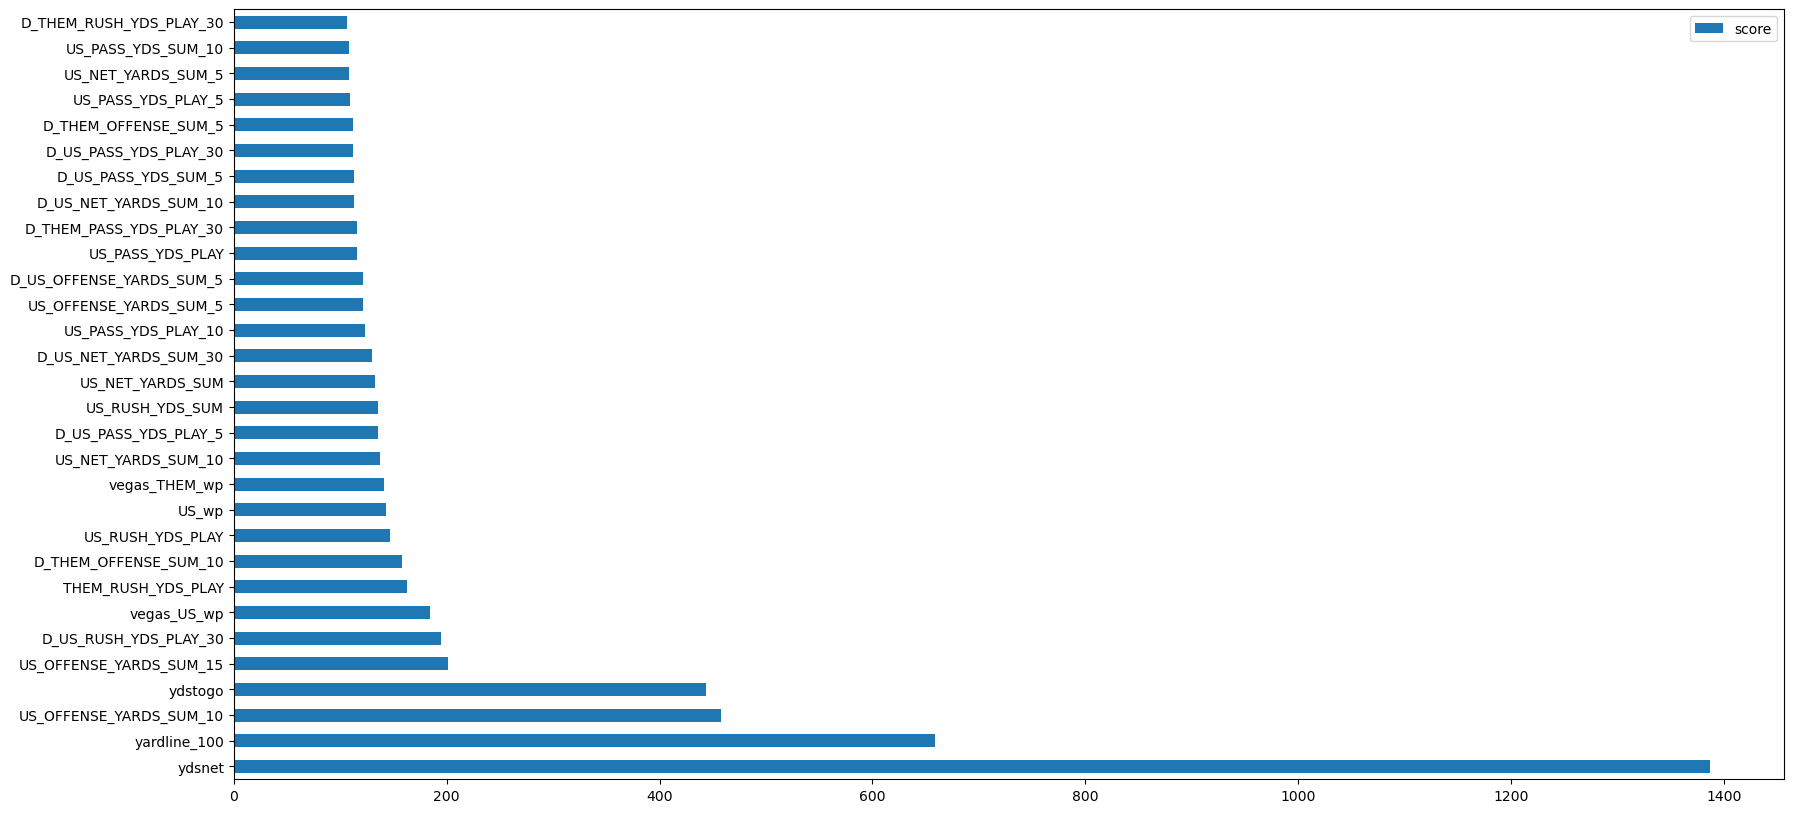

In [70]:
feature_important = xgb0.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(30, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

Note the five most more important factors are 1) The length of the current drive. (Momentum)  2) the current yard line or field position.  3) The number of yards gained in the last 10 plays. (Momentum) 4) How far to go for a 1st down.  5) Total offensive yards in the last 15 plays. (Momentum)  So, of the top 5 variables, 3 are momentum related.

This a great model, but we are using a TON of independent variables (534 to be exact).  Can we reduce the number of variables and get similar accuracy?  Let's try the top 30 most important variables.

In [71]:
df_whole_model.shape

(1260, 531)

### 5.0  Build a Model with a Sub-Set of the derived Variables <a id="Five"></a>

Grab the most predictive 30 column names.

In [72]:
x30=data.head(30).index.to_list()

Make another list that has the id fields

In [73]:
keys=['FOURTH_CONV','MODELING_GROUP','BETTY','posteam','game_id']

Combine the lists.

In [74]:
x30=keys+x30


In [75]:
Select the proper fields from the training and testing data sets.

SyntaxError: invalid syntax (2008674915.py, line 1)

In [ ]:
df_training=df_training[x30]

In [ ]:
df_testing=df_testing[x30]

Build a model with the reduced set of independent variables.

In [ ]:
features = [x for x in df_training.columns if x not in ['FOURTH_CONV','MODELING_GROUP','BETTY','posteam','game_id']]  
dependent=pd.DataFrame(df_training['FOURTH_CONV'])
independent=df_training.drop(columns=['FOURTH_CONV','MODELING_GROUP','BETTY','posteam','game_id'])


xgb0 = XGBClassifier(objective = 'binary:logistic',learning_rate = lr_vals,
                                 n_estimators=estimator_vals,max_depth=md_vals,min_child_weight=mcw_vals,gamma=gamma_vals,
                                        max_delta_step=mds_vals);
xgb0.fit(independent, dependent) 
df_training=df_training.copy()
df_training['P_FOURTH_CONV']= xgb0.predict_proba(df_training[features])[:,1];
df_training=df_training.copy()
df_training['Y_FOURTH_CONV'] = np.where(((df_training.P_FOURTH_CONV <= .5)), 0, 1)
df_training=df_training.copy()
print('Training Data -- 1999 through 2021')                           
print("Accuracy : %.4g" % metrics.accuracy_score(df_training['FOURTH_CONV'].values, df_training['Y_FOURTH_CONV']))
print("AUC Score (Train): %f" % metrics.roc_auc_score(df_training['FOURTH_CONV'], df_training['P_FOURTH_CONV']))
print("Precision Score (Train): %f" % metrics.precision_score(df_training['FOURTH_CONV'], df_training['Y_FOURTH_CONV']));

df_testing=df_testing.copy()
df_testing['P_FOURTH_CONV']= xgb0.predict_proba(df_testing[features])[:,1];
df_testing=df_testing.copy()
df_testing['Y_FOURTH_CONV'] = np.where(((df_testing.P_FOURTH_CONV <= .5)), 0, 1)

print('Testing Data -- 2022 and 2023')
print("Accuracy : %.4g" % metrics.accuracy_score(df_testing['FOURTH_CONV'].values, df_testing['Y_FOURTH_CONV']))
print("AUC Score (Testing): %f" % metrics.roc_auc_score(df_testing['FOURTH_CONV'], df_testing['P_FOURTH_CONV']))
print("Precision Score (Testing): %f" % metrics.precision_score(df_testing['FOURTH_CONV'], df_testing['Y_FOURTH_CONV']))

In [ ]:
df_testing.shape

We can get similar results by only using 30 independent variables.

### 6.0  Interpret the Results <a id="six"></a>

In [ ]:
df=df_testing[df_testing['BETTY']==615686]
df=df[['FOURTH_CONV','BETTY','game_id','ydstogo','P_FOURTH_CONV','Y_FOURTH_CONV']]
df

Let's look at a specific example. How about the Lions' failed fourth-down attempt against the 49ers in the NFC Championship game? According to our model, before the snap of the ball, the chances of converting were about 20%. Or, there was an 80% chance his team would not convert the fourth down. If Dan Campbell knew these odds, would he make the same decision? I guess that he'd take the three points.

Let's take a look at the least riskiest teams in 2023.  That is, what teams decided to go for it on first down with the highest odds of converting.

In [ ]:

df_testing['year'] = df_testing['game_id'].str.slice(0, 4)
df_testing=df_testing[df_testing['year']=='2023']


In [ ]:

grouped_df = pd.DataFrame(df_testing.groupby('posteam')['P_FOURTH_CONV'].agg(['mean', 'min','max','count']).reset_index())
grouped_df=grouped_df.sort_values(by=['mean'],ascending=[False])
grouped_df.head(5)

Based on the model, Denver, Tampa Bay, Philadelphia, Minnesota and Baltimore took the least risky chances on fourth down in 2023. One could infer that the coaches of these teams have a good sense of what the model is saying. They go for it on fourth down when they are more likely to convert. In other words, the coaching staff of these teams make the best decisions on fourth down.

Now lets look at the most risky teams.


In [ ]:
grouped_df.tail(5)

Pittsburgh, Houston, New England, Arizone and the New York Football Giants are at the bottom of the list. Of course, this doesn't account for the game situation. Likely, some of the low-probability attempts occurred late in the game when a team was losing and desperate to turn a probable loss into a win. Nonetheless, one could infer that the coaching staff of these teams make the worst decisions about when to "go for it" on fourth down.

Now, let's look at the relationship between the actual conversion rate by team and the probability to convert by team. By comparing these metrics, we can identify the teams that are most effective at converting on 4th down. For example, if a team converts 90% of their 4th down attempts and the probability of converting these attempts in aggregate is 50%, you'd say they are really good at converting on 4th down.  

To simplify things, we will create a ratio by dividing the actual conversion rate for each team by the average probability to convert for each team.    A ratio of 1 means that a team converts on 4th down as much as expected. A ratio greater than one implies the team converts more than expected, and a ratio less than one means the team converts less than expected.

In [ ]:
YY=df_testing

tips_summed = pd.DataFrame(YY.groupby(['posteam'])[['P_FOURTH_CONV', 'FOURTH_CONV']].mean())

tips_summed['INDEX']=tips_summed['FOURTH_CONV']/tips_summed['P_FOURTH_CONV']
tips_summed=tips_summed.sort_values(by=['INDEX'], ascending=[True])
plotter=tips_summed
plotter=plotter.reset_index()
plotter


According to the table above, in 2023, Dallas was the worst at converting fourth downs. Baltimore was the best.

Below is a chart detailing the probability of converting on the fourth down to the actual conversion rate. Note the strong linear relationship between the predicted and actual values. This is a sign of a very good model. It also indicates that teams that attempt fourth-down conversions when the odds are in their favor convert more frequently.



In [ ]:


y1 = plotter['FOURTH_CONV']
x1 = plotter['P_FOURTH_CONV']
labels=plotter['posteam']
trace = go.Scatter(
    text=labels,
    textposition='bottom left',
    x = x1,
    y = y1,
    mode='markers+text',
name='Net Yards gained on the Durrent Drive')
layout = go.Layout(
    title='Probability of 4th Down Conversion and Actual Conversion Rate on 4th Down',
    xaxis=dict(
        title='Probability to Convert on Fourth Down',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Fourth Down Conversion Rate',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    showlegend=False,
)


# Compute linear trend line
slope, intercept = np.polyfit(x1, y1, 1)
trendline_y = slope * x1 + intercept

# Trend line plot
trendline = go.Scatter(
    x=x1, 
    y=trendline_y, 
    mode='lines', 
    name='Trend line'
)
    
data=[trace,trendline]  
fig = go.Figure(data=data, layout=layout)
#plot_url = py.plot(fig, filename='styling-names')
plotly.offline.iplot(fig, filename='lines')

In general,the farther a team is above the line, the better it is at converting on fourth down. The farther a team is below the line, the worse it is at converting on fourth down. 

Baltimore stands out as a leader in their ability to convert on 4th down, surpassing all others. Denver, on the other hand, excels in assessing when the odds are in their favor, making them the best in this aspect.  

Dallas and Washington are interesting cases. They make good decisions about when to attempt a fourth-down conversion but do a bad job of converting them.

Philadelphia makes good choices on when to attempt and also does a great job of converting. It makes sense, given their "Tush Push" play. Of course, converting on 4th down is easier when you have a QB that squats 600 lbs.

Las Vegas is interesting too.  They do only a fair job of deciding when to go for it on 4th down, but an amazing job of converting.

### 7.0  Conclusion <a id="seven"></a>

The model detailed in this notebook could be easily deployed and run in real time. There is no reason why any coach should be making bad decisions on fourth down. The key is understanding the momentum in the game. Knowing when to "go for it" on fourth down is not a mystery if you can do this. Just play the odds.



I hope this was helpful. Thanks so much for your time.